# DBSCAN: Density-Based Spatial Clustering of Applications with Noise

DBSCAN is a clustering algorithm that groups together data points that are closely packed, while marking points in low-density regions as outliers. It's a pretty similar algorithm to the one we used for K-Means Clustering, but it is more useful for cleaning outliers in datasets and groups based on density. There is no pre-defined $k$ number of clusters to find.

---

## Step-by-Step Procedure
1. **Select a Point**:
   - Start with an arbitrary unvisited point in the dataset.

2. **Determine Neighborhood**:
   - Identify all points within the `eps` radius of the selected point.

3. **Core Point Check**:
   - If the number of points in the neighborhood is greater than or equal to `min_samples`, mark the point as a core point and create a new cluster.
   - Otherwise, mark it as noise (temporarily). It may later become a border point if it falls within the neighborhood of a core point.

4. **Expand Cluster**:
   - For a core point, recursively visit all its neighbors and their neighbors (within `eps`) to add points to the cluster.

5. **Repeat**:
   - Continue selecting unvisited points until all points are processed.

6. **Output**:
   - Clusters of points and a set of noise points (outliers).

---

![DBSCAN Digram](dbscan_diagram.png)

(Image from KDNuggets)

| **Advantages**                      | **Disadvantages**                                                                           |
|-------------------------------------|--------------------------------------------------------------------------------------------|
| Handles Arbitrary Shapes            | Parameter Sensitivity: The quality of clustering depends heavily on the choice of `eps` and `min_samples`. |
| Robust to Noise                     | High Dimensionality: Struggles with high-dimensional datasets due to the curse of dimensionality.             |
| No Predefined Number of Clusters (could also be a disadvantage)    |                                                                                            |




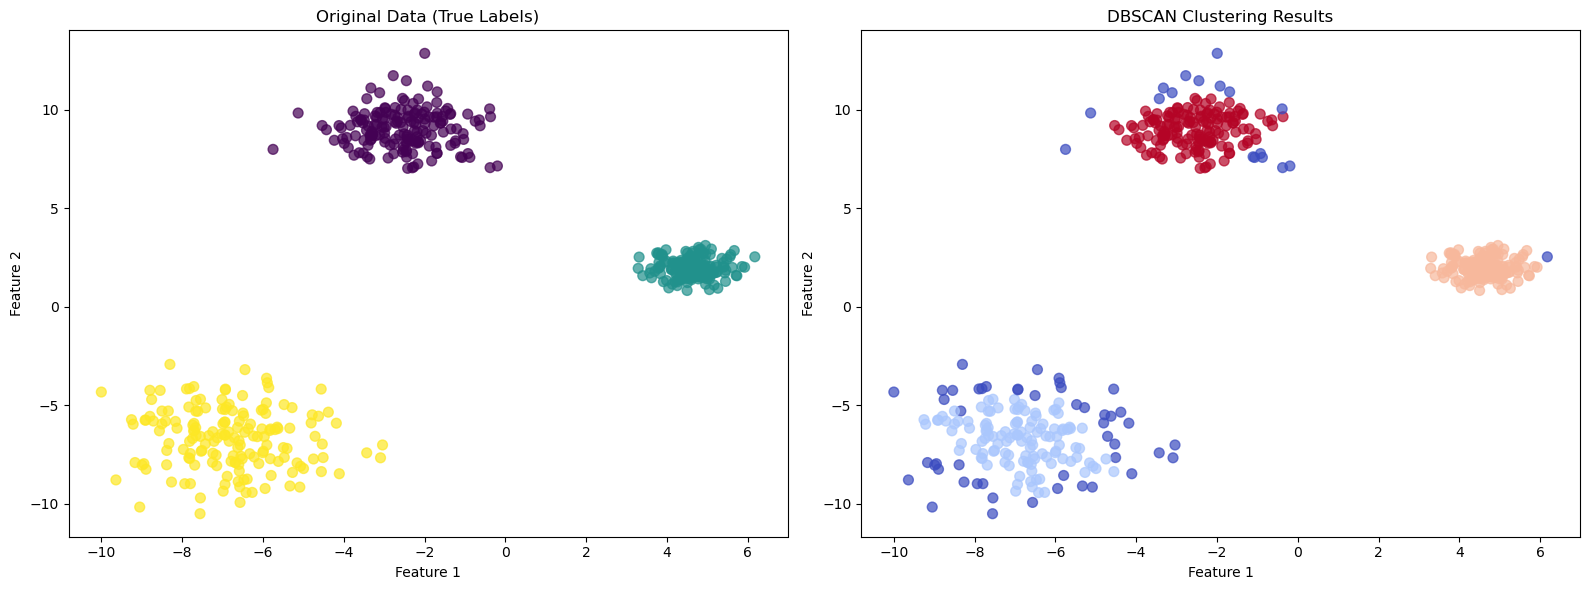

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN

# Generate clustered data (blobs)
n_samples = 500
n_features = 2
n_clusters = 3
cluster_std = [1.0, 0.5, 1.5]  # Standard deviation for each cluster

X, y_true = make_blobs(
    n_samples=n_samples,
    centers=n_clusters,
    cluster_std=cluster_std,
    random_state=42
)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
y_dbscan = dbscan.fit_predict(X)

# Visualize the original data
plt.figure(figsize=(16, 6))

# Subplot 1: Original data with true labels
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y_true, cmap='viridis', s=50, alpha=0.7)
plt.title('Original Data (True Labels)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Subplot 2: DBSCAN clustering results
plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=y_dbscan, cmap='coolwarm', s=50, alpha=0.7)
plt.title('DBSCAN Clustering Results')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Show the plots
plt.tight_layout()
plt.show()


**Great**, it looks like our model correctly identified the clusters, and it definitely prevented more outliers in noisier clusters! To see what is going on behind the scenes, let's code it out and graph each step.

## Step 1: Original Data

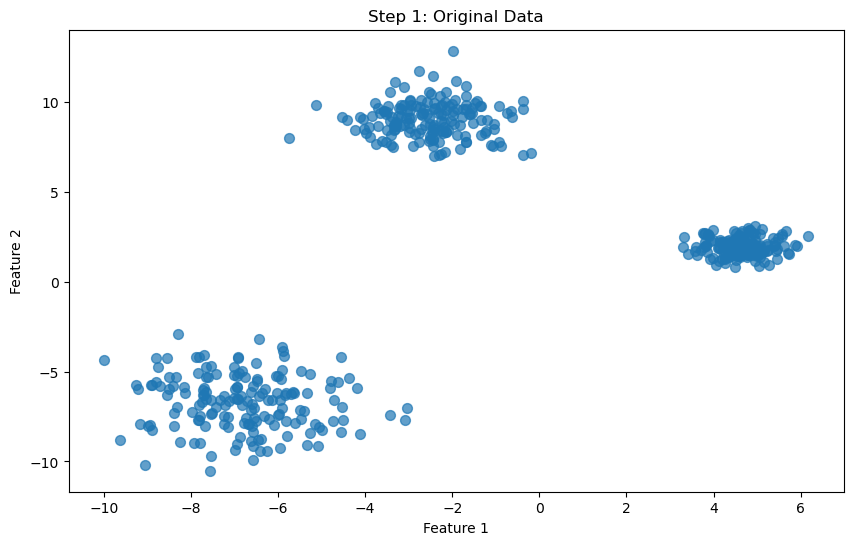

In [56]:
from sklearn.neighbors import NearestNeighbors

# Parameters for DBSCAN
eps = 0.5
min_samples = 5

plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], s=50, alpha=0.7)
plt.title('Step 1: Original Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()



## Step 2: Compute Neighborhoods

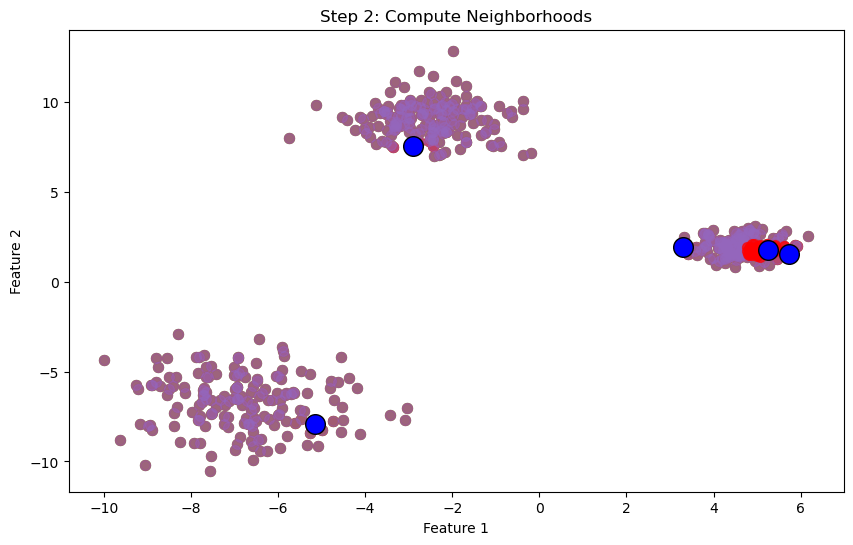

In [57]:
neigh = NearestNeighbors(radius=eps)
neigh.fit(X)
distances, indices = neigh.radius_neighbors(X)

plt.figure(figsize=(10, 6))
for i in range(5):  # Show neighborhoods for a few points
    plt.scatter(X[:, 0], X[:, 1], s=50, alpha=0.5)
    point = X[i]
    neighbors = X[indices[i]]
    plt.scatter(neighbors[:, 0], neighbors[:, 1], color='red', s=50, alpha=0.7)
    plt.scatter(point[0], point[1], color='blue', s=200, edgecolor='black', zorder=5)
plt.title('Step 2: Compute Neighborhoods')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

## Step 3: Identify Core Points

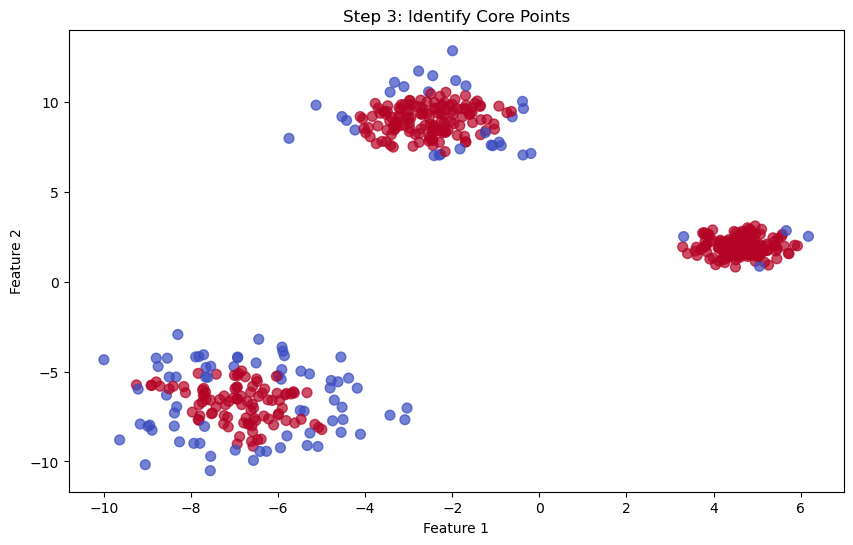

In [58]:
core_points = np.array([len(n) >= min_samples for n in indices])

# print(core_points)

plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=core_points, cmap='coolwarm', s=50, alpha=0.7)
plt.title('Step 3: Identify Core Points')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

## Step 4: Expand Clusters

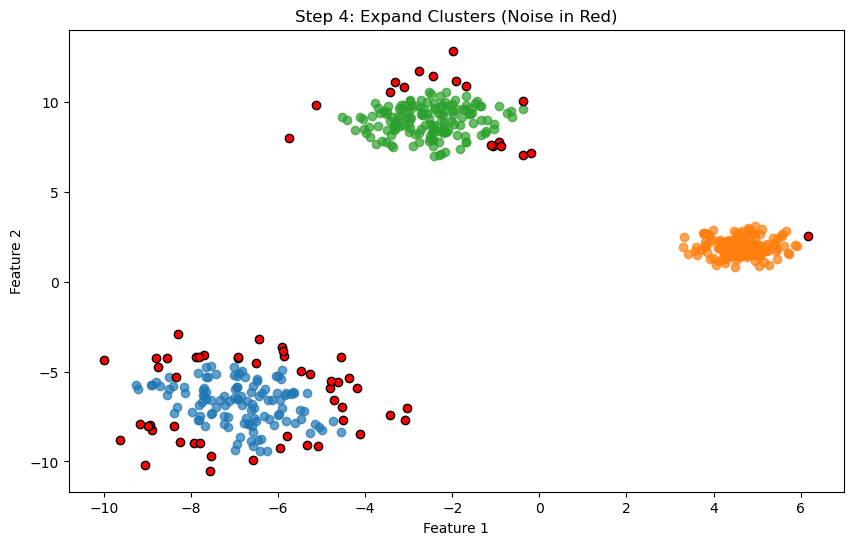

In [59]:
visited = np.zeros(X.shape[0], dtype=bool)  # Track processed points
clusters = -np.ones(X.shape[0], dtype=int)  # Initialize all points as noise (-1)
cluster_id = 0

# Recursive function to expand clusters
def expand_cluster(point_idx, cluster_id):
    # Add the point to the cluster
    clusters[point_idx] = cluster_id
    visited[point_idx] = True
    
    # Find neighbors of the current point
    neighbors = indices[point_idx]
    
    # If the point is a core point, recursively expand
    if len(neighbors) >= min_samples:
        for neighbor_idx in neighbors:
            if not visited[neighbor_idx]:
                expand_cluster(neighbor_idx, cluster_id)

# Iterate over points to build clusters
for idx, is_core in enumerate(core_points):
    if not visited[idx] and is_core:
        # Start a new cluster
        expand_cluster(idx, cluster_id)
        cluster_id += 1

# Visualize the clustering result & highlight noise points in red
plt.figure(figsize=(10, 6))
for cid in range(cluster_id):  # Plot clusters
    cluster_points = X[clusters == cid]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], alpha=0.7)
    
# Plot noise points
noise_points = X[clusters == -1]
plt.scatter(noise_points[:, 0], noise_points[:, 1], color='red', edgecolor='black')
plt.title('Step 4: Expand Clusters (Noise in Red)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


**Note that all the non-red points are in some cluster.** The red points are classified as noise, some of which will be handled in the next step.

## Step 5: Handle Border Points

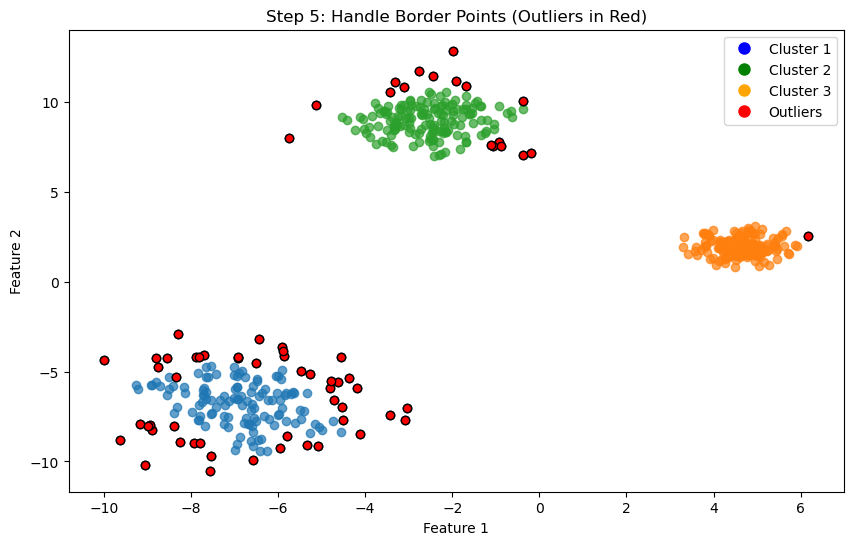

In [64]:
from matplotlib.lines import Line2D

# Identify border points and assign to clusters
border_points = (clusters == -1) & (np.array([np.any(core_points[indices[i]]) for i in range(len(X))]))
clusters[border_points] = cluster_id  # Assign border points to the nearest cluster

# Visualize the clustering result, highlighting:
# - Noise points (not part of clusters) in red
# - Non-border, non-cluster points in black
plt.figure(figsize=(10, 6))

# Plot clusters
for cid in range(cluster_id):
    cluster_points = X[clusters == cid]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], alpha=0.7)

# Plot noise points (red)
noise_points = X[(clusters == -1) & ~border_points]  # True noise points
plt.scatter(noise_points[:, 0], noise_points[:, 1], color='red', edgecolor='black')

# Plot non-border, non-cluster points (black)
non_cluster_points = X[(clusters == -1) & ~core_points]  # Non-border, non-core points
plt.scatter(non_cluster_points[:, 0], non_cluster_points[:, 1], color='Red', edgecolor='black')

# Add legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Cluster 1', markerfacecolor='blue', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Cluster 2', markerfacecolor='green', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Cluster 3', markerfacecolor='orange', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Outliers', markerfacecolor='red', markersize=10)
]
plt.legend(handles=legend_elements)

plt.title('Step 5: Handle Border Points (Outliers in Red)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


**And we're done!** Notice that this removed some of the noise at the border in the **medium-noisy** and **highly-noisy** clusters (top middle and bottom left). 

## Experiments:

You can tune the parameters `eps` and `min_samples` to change the sensitivity of the model, capturing more or less outliers. If you tune `eps` small enough, the model will identify more than 3 clusters! Feel free to mess around with the `make_blobs` generator function, too.